In [323]:
import os 

In [324]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [325]:
os.chdir("../.")

In [326]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [327]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [328]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    """
    Data Transformation Configuration
    """
    root_dir: Path
    transformed_data_file: Path
    customer_path: Path
    product_path: Path
    train_data_file: Path
    test_data_file: Path

In [329]:
from BankProducts.constants import *
from BankProducts.utils.common import read_yaml, create_directories

In [330]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,    
        params_filepath = PARAMS_FILE_PATH,
        #schema_filepath = SCHEMA_FILE_PATH,
        ):
       
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        #self.schema = read_yaml(schema_filepath)        
    
        create_directories([self.config.artifacts_root])
        
    def get_data_transformation_config(self)-> DataTransformationConfig:
        """
        Returns Data Transformation Configuration
        """
        config = self.config.data_transformation
        
        create_directories([self.config.artifacts_root])
        
        data_transformation_config = DataTransformationConfig(
            root_dir=Path(config.root_dir),
            transformed_data_file= Path(config.transformed_data_file),
            product_path= Path(config.product_path),
            customer_path= Path(config.customer_path),
            train_data_file= Path(config.train_data_file),
            test_data_file= Path(config.test_data_file)
            )
        
        
        return data_transformation_config
    

In [331]:



import os  
from BankProducts import logger
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

     


In [ ]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        #self.data = None
        #self.transformed_data = None
        
    def join_datasets(self):
        """
        Join customer and product datasets"""    
        try:
            customer_data = pd.read_csv(self.config.customer_path)
            product_data = pd.read_csv(self.config.product_path)

            # Ensure the directory for saving exists
            output_dir = os.path.dirname(self.config.transformed_data_file)
            os.makedirs(output_dir, exist_ok=True)

            # Join operation
            joined_data = pd.merge(customer_data, product_data, how="left",
                                left_on="existing_products", right_on="product_name")
            
            #drop unnecessary columns
            joined_data = joined_data.drop(columns=['existing_products'], errors='ignore')  # Drop 'product_name' if it exists
            
            #check the dataset head
            print(joined_data.head())
            
            
            # Save the joined data
            joined_data.to_csv(self.config.transformed_data_file, index=False)

        except Exception as e:
                print(f"Error joining datasets: {e}")
                
    def transform_data(self):
        """
        Transform the data as per the requirements
        """
        try:
            # Load the data
            self.data = pd.read_csv(self.config.transformed_data_file)
            # Perform transformations
            print(self.data.head())
            
            print(":"*100)
            
            self.data.info()
            print(":"*100)
            
            self.data.describe()
            print(":"*100)
            print(self.data.columns)
            print(":"*100)
            
            #drop na
            self.data.dropna(inplace=True
                             )
            #check null values
            print(self.data.isnull().sum())
            
            #drop unnecessary columns
            self.data = self.data.drop(columns=[['customer_id','named', 'eligibility', 'description']], errors='ignore')
            
            
            #plot "product_name" histogram based of gender using seaborn
            plt.figure(figsize=(10, 6))
            ax = sns.histplot(data=self.data, x='product_name', hue='gender', multiple='stack')

            # Add separated count labels above each segment
            for container in ax.containers:
                # Add offset so overlapping labels are vertically separated
                for bar in container:
                    height = bar.get_height()
                    if height > 0:
                        ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            bar.get_y() + height / 2,  # Place label at the middle of the segment
                            f'{int(height)}',
                            ha='center',
                            va='center',
                            fontsize=9,
                            color='white',  # or 'black' depending on your bar color
                            weight='bold'
                        )


            plt.title("Product Name Histogram by Gender")
            plt.tight_layout()
            plt.show()
                        
            #plot "age" histogram
            plt.figure(figsize=(10,6))
            plt.hist(self.data["age"], bins=10, edgecolor='black', color= "orange", alpha=0.7)
            plt.title("Age Frequency Distribution")
            plt.xlabel("Age")
            plt.ylabel("Frequency")
            plt.savefig("age_histogram.png")
            
        
           
            #plot "product_name" vs "age" bar plot
            plt.figure(figsize=(10,6))
            plt.bar(self.data["product_name"], self.data["age"], color="green")
            plt.title("Product Name vs Age Bar Plot")
            plt.xlabel("Product Name")
            plt.ylabel("Age")
            plt.savefig("product_name_vs_age_bar_plot.png")
            
            #feature selection
            # If it's a categorical variable like a string, correlation won't work correctly
            correlation_matrix = self.data.select_dtypes.corr()
            
            plt.figure(figsize=(10, 6))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
            plt.title("Correlation Matrix")
            plt.show()
            plt.savefig('correlation_matrix.png')
     
            #feature engineering
            # Convert categorical variables to numerical using OneHotEncoder
            categorical_features = self.data.select_dtypes(include=['object']).columns.tolist()
            numerical_features = self.data.select_dtypes(exclude=['object']).columns.tolist()
            categorical_features.remove('product_name')  # Exclude target variable
            
            #LabelEncoder
            
            le = LabelEncoder()
            self.data['product_name'] = le.fit_transform(self.data['product_name']) 
            
        
            # OneHotEncoder 
           
            # Create a ColumnTransformer to handle categorical and numerical features
            preprocessor = ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), categorical_features),
                    ('num', SimpleImputer(strategy='mean'), numerical_features)
                ],
                remainder='passthrough'  # Keep other columns as they are
            )
            # Create a pipeline with the preprocessor
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('scaler', StandardScaler())  # Optional: Add a scaler if needed
            ])
            # Fit and transform the data
            transformed_data = pipeline.fit_transform(self.data)
            # Convert the transformed data back to a DataFrame
            transformed_df = pd.DataFrame(transformed_data, columns=pipeline.get_feature_names_out())
            # Save the transformed data to a CSV file
            transformed_df.to_csv(self.config.transformed_data_file, index=False)
            logger.info("Datasets joined and transformed successfully")
            print("Datasets joined and transformed successfully")
            # Ensure the directory for saving exists
            os.makedirs(os.path.dirname(self.config.transformed_data_file), exist_ok=True)
            # Check the shape of the joined data
            print(f"Joined data shape: {transformed_data.shape}")
            
           
            # Example transformation: splitting data into train and test sets
            train_data, test_data = train_test_split(self.data, test_size=0.2)
            self.transformed_data = {
                "train": train_data,
                "test": test_data
            }
            
            #save train_data and test_data to csv files
            train_data.to_csv(self.config.train_data_file, index=False)
            test_data.to_csv(self.config.test_data_file, index=False)
            
        except Exception as e:
            print(f"Error during data transformation: {e}")
            
      

[2025-05-24 15:41:43,643: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-24 15:41:43,645: INFO: common: yaml file: params.yaml loaded successfully]
[2025-05-24 15:41:43,647: INFO: common: created directory at: artifacts]
[2025-05-24 15:41:43,648: INFO: common: created directory at: artifacts]
                            customer_id             name  age  gender  \
0  21103d4d-787e-482f-92ba-5dfa603a8e9e  Peter Hernandez   24    Male   
1  e0a256bb-4d9f-4d77-84fe-940af138912c       James Hale   48    Male   
2  90e58e09-0415-4db9-a8e8-a71678e3cbde    Jennifer Ross   25  Female   
3  e1a486f6-6fda-45ba-a9ce-a5113458a1f0     Austin Klein   41  Female   
4  9a239e51-bca4-4481-a61c-568732524343     Kevin Thomas   52  Female   

                         occupation  annual_income marital_status  \
0                       Pathologist       64597.69        Married   
1  Scientific laboratory technician      124771.88       Divorced   
2                     Herpetologi

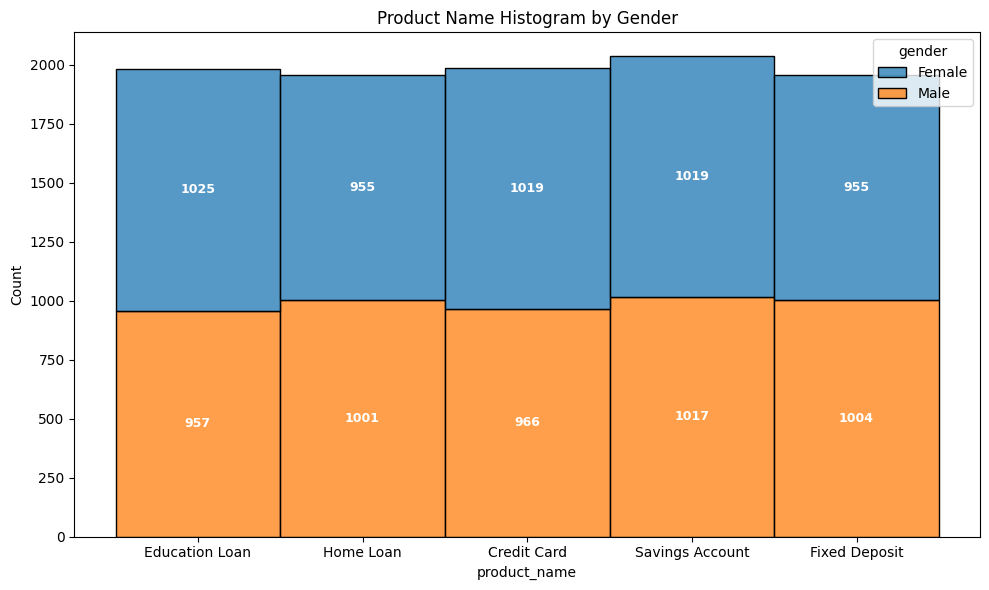

[2025-05-24 15:46:55,191: INFO: 2235768441: Datasets joined and transformed successfully]
Datasets joined and transformed successfully
Joined data shape: (9918, 19897)
Error during data transformation: 'numpy.ndarray' object has no attribute 'corr'


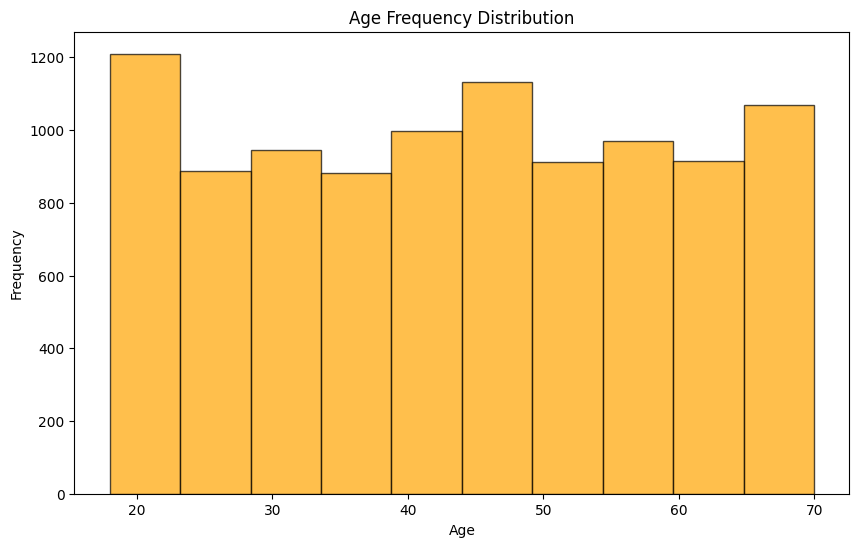

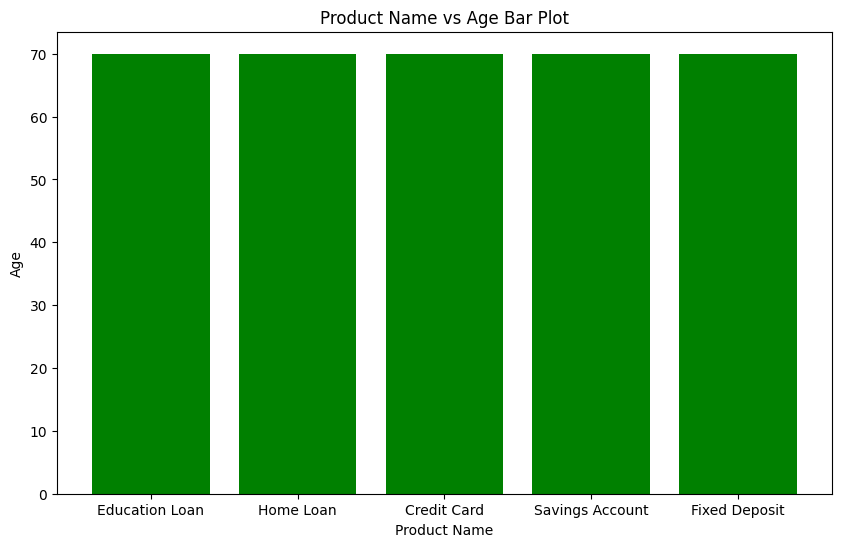

In [333]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    
    data_transformation = DataTransformation(config=data_transformation_config)
    
    data_transformation.join_datasets()
    data_transformation.transform_data()
    

except Exception as e:
    print(f"An error occurred: {e}")
    
    